In [111]:
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time
import cv2
import optuna
from torchvision import transforms as T, models

from optuna.trial import TrialState

%matplotlib inline

In [112]:
data_dir = 'SatData/'
print(os.listdir(data_dir))

['cloudy', '.DS_Store', 'water', 'green_area', 'desert']


In [113]:
d = "cpu"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [114]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        # print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        # print(self.data)
        self.class_map = {"desert" : 0, "water": 1,"green_area": 2,"cloudy": 3}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [115]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [116]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

113 36 29


In [117]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


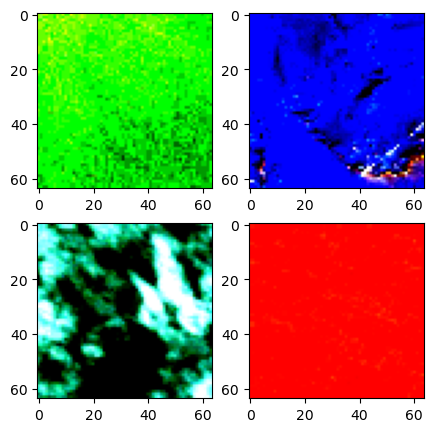

In [118]:
plot_data_loader(data_loader_test,[2,2])

In [119]:
DEVICE = d
BATCHSIZE = 32
CLASSES = 4
EPOCHS = 10
N_TRAIN_EXAMPLES = len(data_loader_train)
N_VALID_EXAMPLES = len(data_loader_val)

In [120]:
def define_model():
    model = models.vgg16(weights=None)
    return model

In [121]:
def objective(trial):
    # Generate the model.
   
    model = define_model()
    model.to(DEVICE)
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader, valid_loader = data_loader_train, data_loader_val

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break
           
            data, target = data[0].to(DEVICE), target[0].to(DEVICE)
            data = data.reshape(1, 3, 64, 64)

            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data[0].to(DEVICE), target[0].to(DEVICE)
                data = data.reshape(1, 3, 64, 64)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [122]:
study = optuna.create_study(direction="maximize",study_name="hyperparameter_optimization_vgg16")
study.optimize(objective, n_trials=40, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-29 18:16:13,263] A new study created in memory with name: hyperparameter_optimization_vgg16
[I 2022-11-29 18:16:40,364] Trial 0 finished with value: 0.034482758620689655 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00010978245076512588}. Best is trial 0 with value: 0.034482758620689655.
[I 2022-11-29 18:17:14,260] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'Adam', 'lr': 0.0030059876143338593}. Best is trial 0 with value: 0.034482758620689655.
[I 2022-11-29 18:17:53,865] Trial 2 finished with value: 0.034482758620689655 and parameters: {'optimizer': 'Adam', 'lr': 3.866953567831951e-05}. Best is trial 0 with value: 0.034482758620689655.
[I 2022-11-29 18:18:09,351] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'SGD', 'lr': 0.0013628514393442322}. Best is trial 0 with value: 0.034482758620689655.
[I 2022-11-29 18:18:31,360] Trial 4 finished with value: 0.034482758620689655 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00015555872845453

Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  24
  Number of complete trials:  16
Best trial:
  Value:  0.034482758620689655
  Params: 
    optimizer: RMSprop
    lr: 0.00010978245076512588


In [123]:
optuna.visualization.plot_parallel_coordinate(study)

In [124]:
optuna.visualization.plot_contour(study)

In [125]:
optuna.visualization.plot_slice(study)

In [126]:
optuna.visualization.plot_param_importances(study)

In [127]:
optuna.visualization.plot_optimization_history(study)

In [128]:
optuna.visualization.plot_intermediate_values(study)